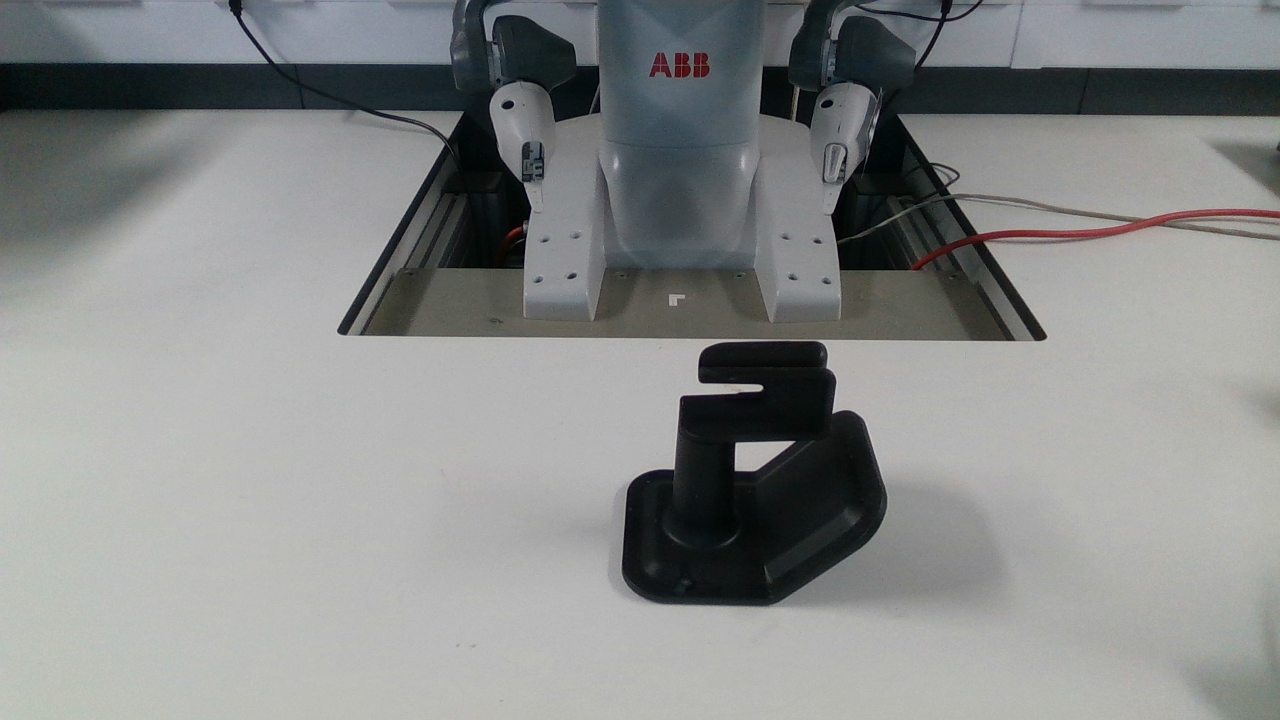

In [18]:
from PIL import Image
from direct.preprocessor import Preprocessor, pose_inv, SceneData
import numpy as np
import open3d as o3d

demo_rgb = np.array(Image.open("../data/live_spray_rgb.png"))
demo_depth = np.array(Image.open("../data/live_spray_depth.png")) 
demo_mask = np.array(Image.open("../data/live_spray_mask.png"))

live_rgb = np.array(Image.open("../data/demo_spray_rgb.png"))
live_depth = np.array(Image.open("../data/demo_spray_depth.png")) 
live_mask = np.array(Image.open("../data/demo_spray_mask.png"))
T_WC = np.load("../handeye/T_WC_head.npy")
intrinsics = np.load("../handeye/intrinsics.npy")
rgb = Image.fromarray(demo_rgb.astype('uint8'))
rgb

In [19]:
print(np.max(demo_depth))

17329


995


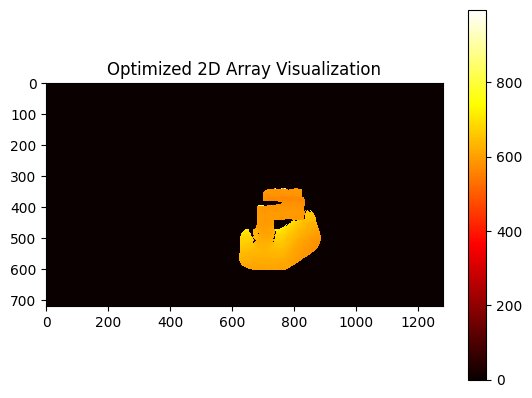

In [20]:
# Assuming demo_rgb is your RGB image and demo_mask is your mask
# Ensure demo_mask is a boolean array and has the same height and width as demo_rgb
import matplotlib.pyplot as plt
demo_mask[demo_mask > 0] = 1
masked_depth = demo_depth * demo_mask

# Convert to PIL Image
masked_image = Image.fromarray(masked_depth)

array_2d = masked_depth.copy()
print(np.max(array_2d))
# Plot the heatmap
plt.imshow(array_2d, cmap='hot', interpolation='nearest')

# Define a threshold for annotation
threshold = np.max(array_2d) * 0.7  # Example: 70% of the max value

# Create a mask for values above the threshold
mask = array_2d > threshold

# Apply annotations only where the mask is True
y_indices, x_indices = np.where(mask)

plt.title('Optimized 2D Array Visualization')
plt.colorbar()  # Add a colorbar for reference
plt.show()

In [21]:
data = SceneData(
    image_0=demo_rgb,
    image_1=live_rgb,
    depth_0=demo_depth,
    depth_1=live_depth,
    seg_0=demo_mask,
    seg_1=live_mask,
    intrinsics_0=intrinsics,
    intrinsics_1=intrinsics,
    T_WC=T_WC
)

processor = Preprocessor()
data.update(processor(data))

In [22]:
print(data["pc0"][:, :3].shape)

(47802, 3)


In [23]:
pcd0 = o3d.geometry.PointCloud()
pcd0.points = o3d.utility.Vector3dVector(data["pc0"][:, :3])
pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(data["pc1"][:, :3])

pcd0_centre = np.mean(data["pc0"][:, :3], axis=0)
pcd1_centre = np.mean(data["pc1"][:, :3], axis=0)
print(pcd0_centre)
print(pcd1_centre)
# diff = pcd0_centre - pcd1_centre
o3d.visualization.draw_geometries([pcd0, pcd1])
# diff

[0.54080445 0.0373418  0.2053804 ]
[ 0.5375884  -0.11493513  0.20040503]
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [28]:
import open3d as o3d
import numpy as np
import copy

# Function to draw registration results
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.transform(transformation)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    o3d.visualization.draw_geometries([source_temp, target_temp])

# Compute FPFH features
voxel_size = 0.01  # Set voxel size for downsampling (adjust based on your data)
source_down = pcd0.voxel_down_sample(voxel_size)
target_down = pcd1.voxel_down_sample(voxel_size)

source_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))
target_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))

source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
    source_down,
    o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 5, max_nn=100))

target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
    target_down,
    o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 5, max_nn=100))

# Global registration using RANSAC
distance_threshold = voxel_size * 1.5
result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    source_down, target_down, source_fpfh, target_fpfh, mutual_filter=False,
    max_correspondence_distance=distance_threshold,
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(), 
    ransac_n=4,
    checkers=[
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9), 
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
    ],
    criteria=o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 500)
)

# Use the result of global registration as the initial transformation for ICP
trans_init = result.transformation

# Apply ICP
threshold = 0.02  # Set a threshold for ICP, this depends on your data
reg_p2p = o3d.pipelines.registration.registration_icp(
    pcd0, pcd1, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())

# Get the transformation matrix
T_delta_base = reg_p2p.transformation

# Draw the result
draw_registration_result(pcd0, pcd1, T_delta_base)

print(T_delta_base)

def calculate_rmse(source, target, transformation):
    source.transform(transformation)
    
    # KDTree for searching nearest neighbors
    target_tree = o3d.geometry.KDTreeFlann(target)

    distances = []
    for point in source.points:
        _, idx, dist = target_tree.search_knn_vector_3d(point, 1)
        distances.append(dist[0])

    rmse = np.sqrt(np.mean(distances))
    return rmse

# Apply the calculated RMSE function
rmse = calculate_rmse(copy.deepcopy(pcd0), pcd1, T_delta_base)
print(f"RMSE: {rmse}")



RuntimeError: [1;31m[Open3D Error] (RegistrationResult open3d::pipelines::registration::RegistrationICP(const geometry::PointCloud &, const geometry::PointCloud &, double, const Eigen::Matrix4d &, const TransformationEstimation &, const ICPConvergenceCriteria &)) /Users/renes/development/open3d_work/Open3D/cpp/open3d/pipelines/registration/Registration.cpp:128: TransformationEstimationPointToPlane and TransformationEstimationColoredICP require pre-computed normal vectors for target PointCloud.
[0;m

In [19]:
from scipy.spatial.transform import Rotation as R

def translation_from_matrix(matrix):
    """Extracts the translation vector from a 4x4 homogeneous transformation matrix."""
    return matrix[:3, 3]

def euler_from_matrix(matrix):
    """Extracts the quaternion from a 4x4 homogeneous transformation matrix."""
    rotation_matrix = matrix[:3, :3].copy()
    rotation = R.from_matrix(rotation_matrix)
    return rotation.as_euler(seq="XYZ", degrees=True)

trans = translation_from_matrix(T_delta_base)
rotation = euler_from_matrix(T_delta_base)

print(trans, rotation)

[0.14343193 0.41713163 0.01285603] [ 2.21225953e-02  1.46855369e+00 -3.23223851e+01]


In [20]:
PointCloud = np.ndarray

def rotate_pointcloud(pcd: PointCloud, angle_z: float):
    R = np.eye(3)
    cosine = np.cos(angle_z)
    sine = np.sin(angle_z)
    R[0, 0] = cosine
    R[1, 1] = cosine
    R[0, 1] = -sine
    R[1, 0] = sine

    pcd[:3, :] = R @ pcd[:3, :]
    return R, pcd

def find_translation(pcd0: PointCloud, pcd1: PointCloud) -> np.ndarray:
    pcd0_centre = np.mean(pcd0[:, :3], axis=0)
    pcd1_centre = np.mean(pcd1[:, :3], axis=0)
    return pcd1_centre - pcd0_centre
    
R_mtx, rotated_pcd0 = rotate_pointcloud(data["pc0"], rotation[-1])
translation = find_translation(rotated_pcd0, data["pc1"])

print(translation)
T_delta_base = np.eye(4)
T_delta_base[:3, :3] = R_mtx
T_delta_base[:3, 3] = translation

T_delta_cam = pose_inv(data["T_WC"]) @ T_delta_base @ data["T_WC"]

print(T_delta_base)

draw_registration_result(pcd0, pcd1, T_delta_base)

[0.00322384 0.15227519 0.00498003]
[[ 0.61653787  0.78732525  0.          0.00322384]
 [-0.78732525  0.61653787  0.          0.15227519]
 [ 0.          0.          1.          0.00498003]
 [ 0.          0.          0.          1.        ]]
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
